# 0. Import packages

First, we import the necessary packages for this exercise.

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import numpy as np
import cartopy.feature as cfeature

# 1. Open simulation data

- Open data from baseline simulations and noTEB simulations. 

In [2]:
def convert_to_mm_h(ds):
    if "pr" in ds:
        ds.pr.values = ds.pr.values * 3600
        ds.pr.attrs["units"] = "mm/h"

    return ds

In [3]:
run_info_list = [("2021070100", 384), 
                 ("2021070112", 372), 
                 ("2021070200", 360),
                 ("2021070212", 348),
                 ("2021070300", 336), 
                 ("2021070312", 324), 
                 ("2021070400", 312)]

ds_ens_list = list()

for configuration in ["baseline", "noTEB"]:
    ds_list = list()

    for run_info in run_info_list:
        ds = xr.open_mfdataset(f"../data/{configuration}_{run_info[0]}_{run_info[1]}_pr_*", engine="netcdf4")
        ds_list.append(ds)

    ds_ens = xr.concat(ds_list, dim="rstart")
    ds_ens_list.append(ds_ens)

ds = xr.concat(ds_ens_list, dim="run_name")
ds = convert_to_mm_h(ds)
ds

<xarray.Dataset>
Dimensions:    (time: 384, lon: 75, lat: 70, run_name: 2, rstart: 7, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2021-07-01T01:00:00 ... 2021-07-17
  * lon        (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.9 6.97 7.04 7.11 7.18
  * lat        (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
    time_bnds  (rstart, time, bnds) datetime64[ns] 2021-07-01 ... 2021-07-17
    crs        int64 0
  * rstart     (rstart) <U10 '2021070100' '2021070112' ... '2021070400'
  * run_name   (run_name) <U8 'baseline' 'noTEB'
Dimensions without coordinates: bnds
Data variables:
    pr         (run_name, rstart, time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
Attributes: (12/33)
    CDI:                       Climate Data Interface version 2.0.6 (https://...
    source:                    ALARO-1 (CY43T2) - SURFEX v8.0
    Conventions:               CF-1.11
    activity_id:               DD
    comment:                   
    contact:                   wout.dewettinck@ugent.be
    ...                        ...
    version_realization_info:  
    creation_date:             2024-11-07T16:06:26Z
    frequency:                 1hr
    StartTime:                 2021-07-01T00:00
    EndTime:                   2021-07-17T00:00
    CDO:                       Climate Data Operators version 2.0.6 (https://...

# 2. Plot the accumulated precipitation for all simulations

- Plot accumulated precipitation

C:\Users\wdwettin\AppData\Local\Temp\ipykernel_62976\4219315611.py:9: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


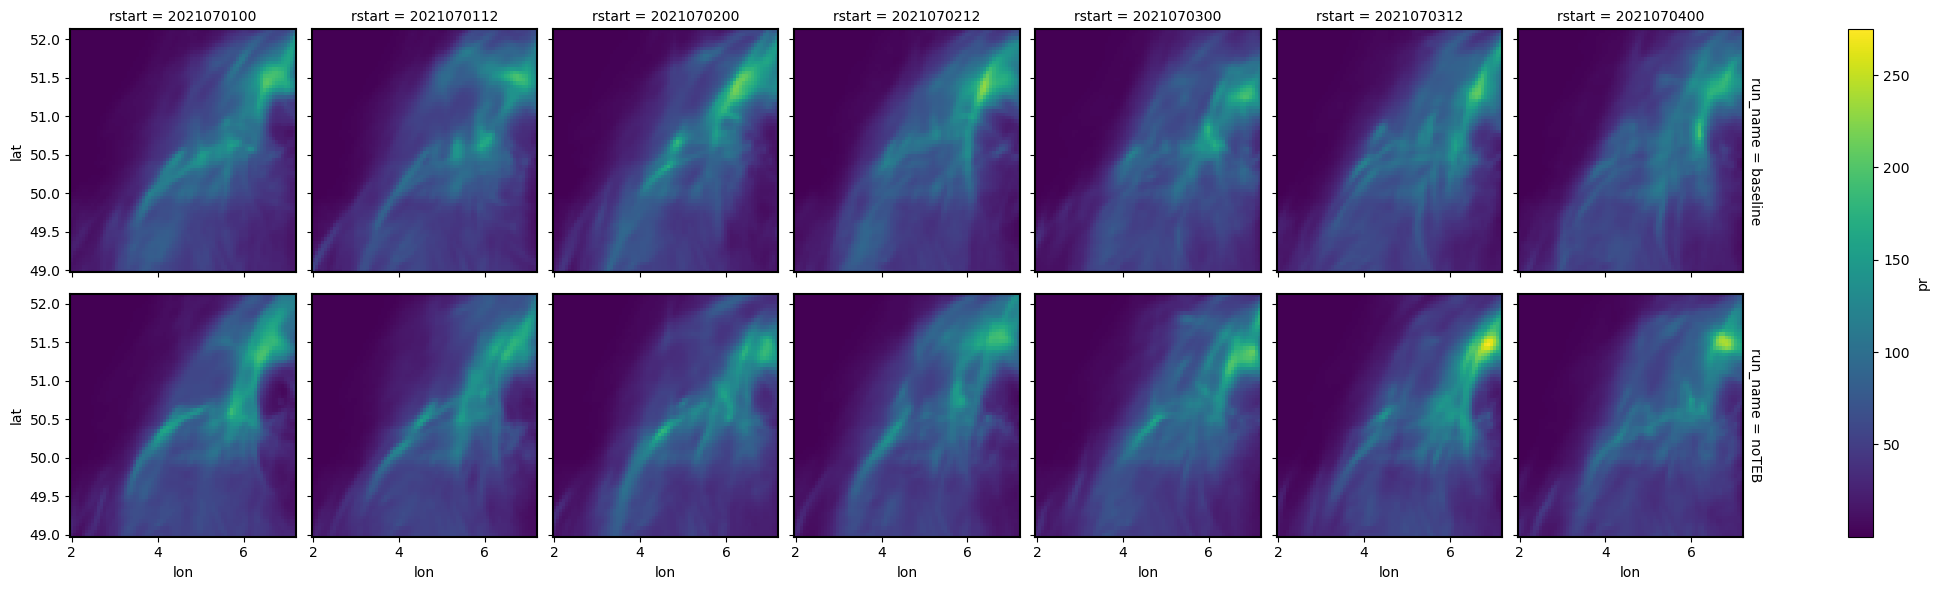

In [60]:
ds_period = ds.sel(time=slice("2021-07-13T09", "2021-07-15T08"))
pr_period = ds_period.pr
pr_period_sum = pr_period.sum(dim="time")
pr_period_sum_ens_mean = pr_period_sum.mean(dim="rstart")
pr_period_sum_ens_std = pr_period_sum.std(dim="rstart")

g = pr_period_sum.plot(col="rstart", row="run_name")

for ax in g.axes.flat:
    for _, spine in ax.spines.items():
        spine.set_visible(True)       # Make the border visible
        spine.set_linewidth(1.5)      # Set the border width
        spine.set_color("black")      # Set the border color

plt.show()

Text(0.5, 0.98, 'Accumulated precipitation between 2021-07-13T09 and 2021-07-15T08')

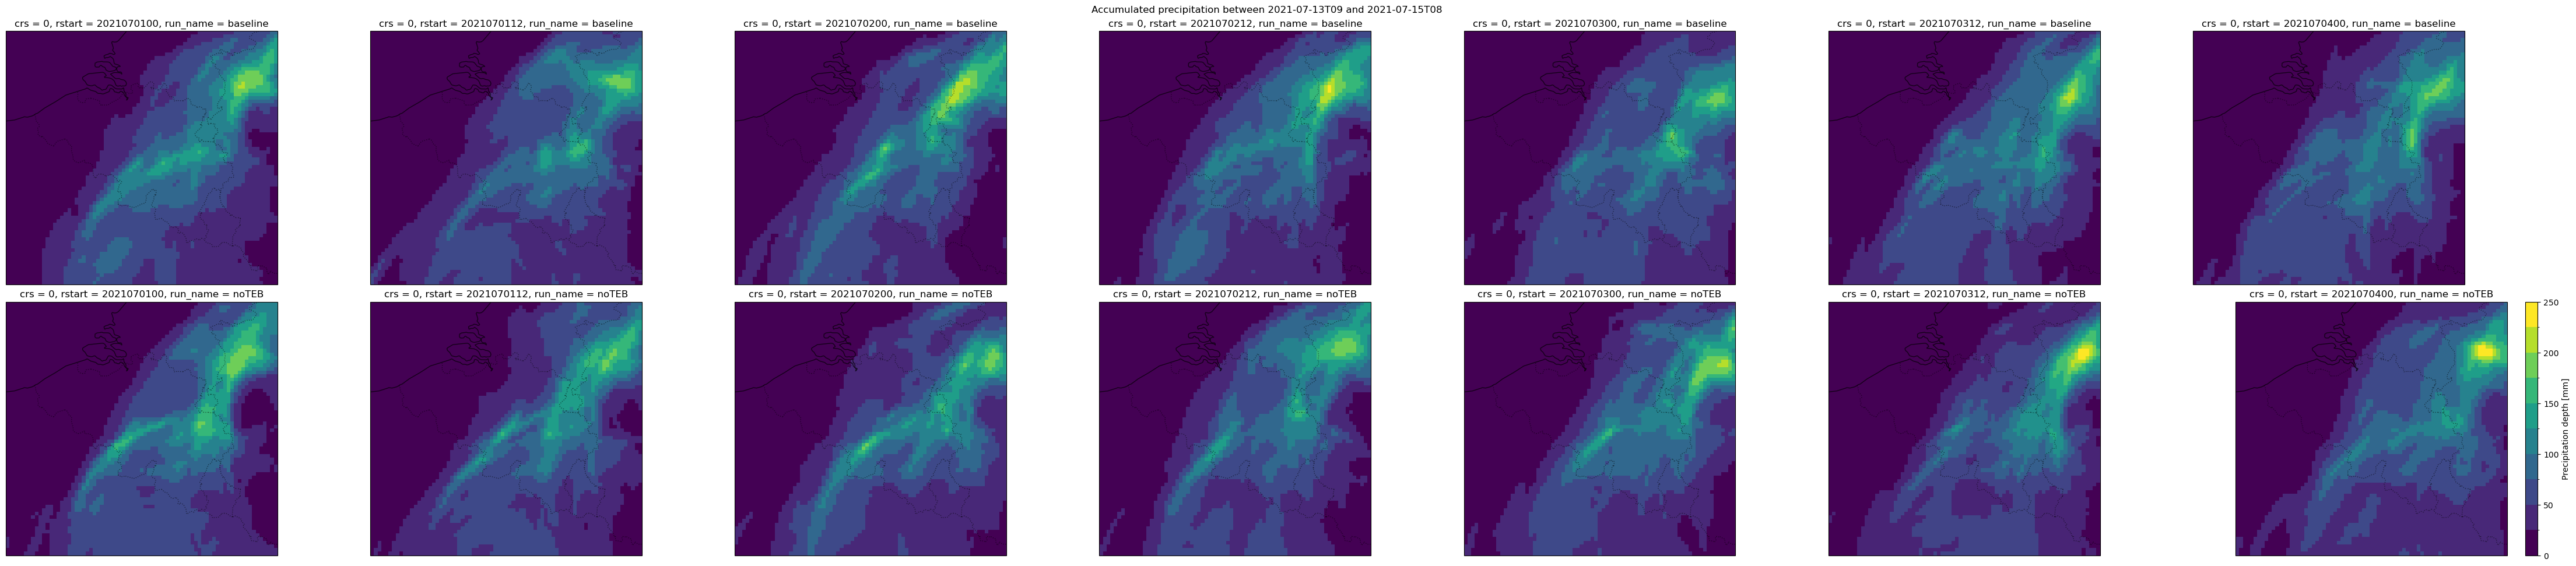

In [41]:
# Select a period out of the the data with tstart and tstop
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_period = ds.sel(time=slice(tstart, tstop))

# Select the precipitation out of the data and sum over time
pr_period = ds_period.pr
pr_period_sum = pr_period.sum(dim="time")

# Choose levels for the plot
levels = np.arange(0, 251, 25)

# Plot the data
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(6.4*7, 4.8*2), layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})

axs.shape

for row_idx in range(2):
    for col_idx in range(7):
        ax = axs[row_idx, col_idx]
        ax.coastlines(alpha=0.7)
        ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
        p = pr_period_sum.isel(run_name=row_idx, rstart=col_idx).plot(ax=ax, x="lon", y="lat", levels=levels, add_colorbar=False)

        dlat = 0.045
        dlon = 0.07
        aspect_ratio = dlon / dlat
        ax.set_aspect(aspect_ratio)

fig.colorbar(p, label="Precipitation depth [mm]")
fig.suptitle(f"Accumulated precipitation between {tstart} and {tstop}", fontsize="large")

In [ ]:

pr_plot = pr_period_sum.plot(ax=ax, x="lon", y="lat", levels=levels, add_colorbar=False)
# Set the title to show the maximum plotted value
ax.set_title(f"Maximum value = {pr_period_sum.max().values:.0f} mm")

ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")

# We found previously that while the resolution in degrees is different for the x- and y-axes, the resolution in kilometres is actually the same. To have this represented on the figure, we should therefore modify the aspect ratio accordingly:
dlat = 0.045
dlon = 0.07
aspect_ratio = dlon / dlat
ax.set_aspect(aspect_ratio)

# We give the color bar and the figure appropriate names
fig.colorbar(pr_plot, label="Precipitation depth [mm]")
fig.suptitle(f"Accumulated precipitation between {tstart} and {tstop}", fontsize="large")

# Show the plot!
plt.show()

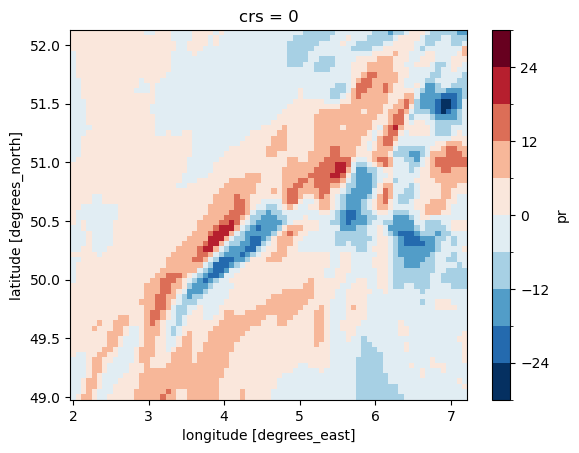

In [21]:
ds_period = ds.sel(time=slice("2021-07-13T09", "2021-07-15T08"))
ds_period_sum = ds_period.sum(dim="time")
ds_period_sum_ens_mean = ds_period_sum.mean(dim="rstart")
ds_period_sum_ens_std = ds_period_sum.std(dim="rstart")

pr_baseline = ds_period_sum_ens_mean.pr.sel(run_name="baseline")
pr_noTEB = ds_period_sum_ens_mean.pr.sel(run_name="noTEB")

(pr_baseline - pr_noTEB).plot(levels=np.arange(-30, 31, 6))

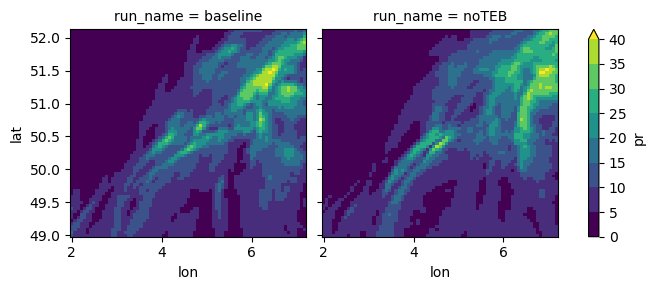

In [31]:
ds_period_sum_ens_std.pr.plot(col="run_name", levels=np.arange(0, 41, 5), extend="max")

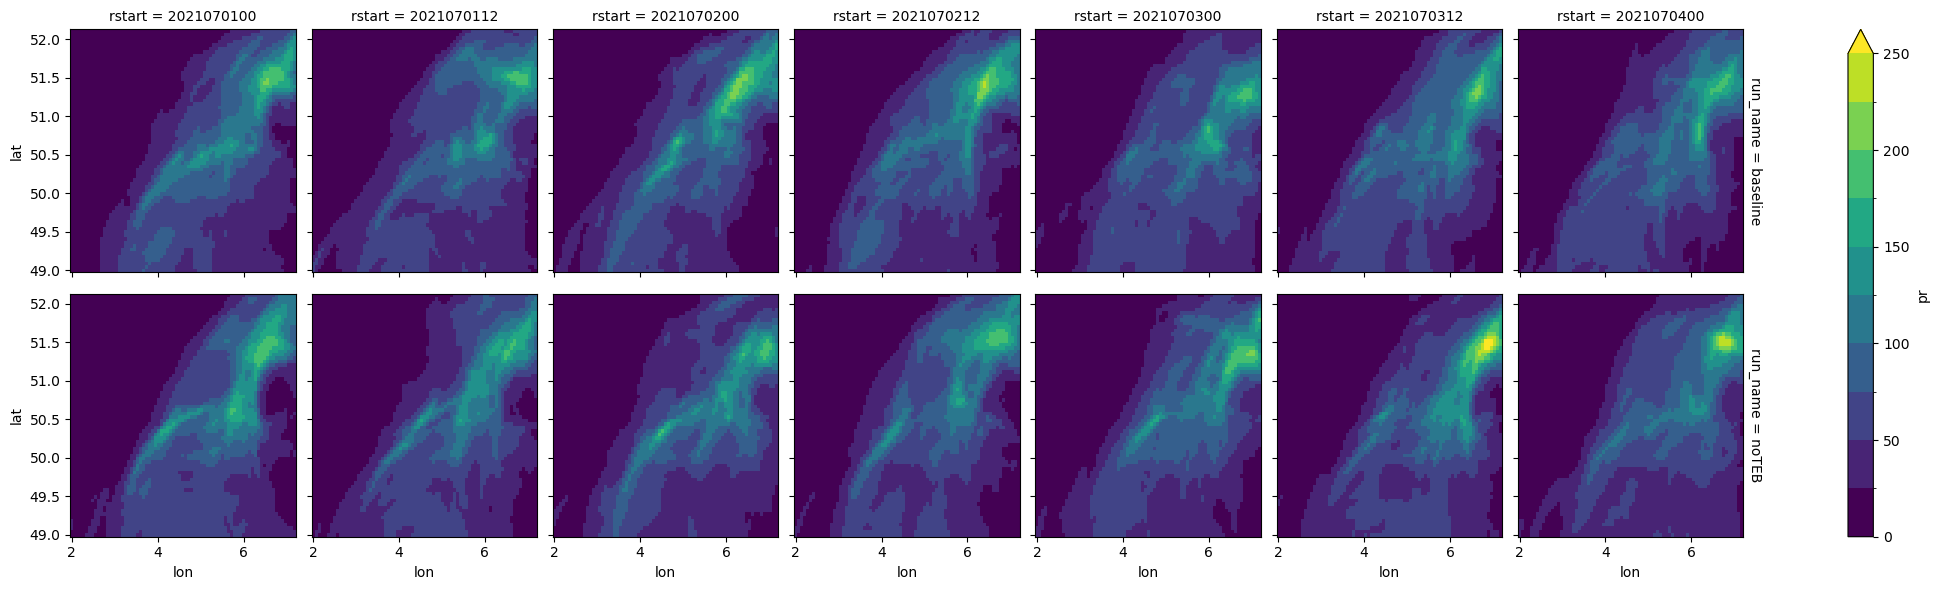

In [28]:
ds_period_sum.pr.plot(col="rstart", row="run_name", levels=np.arange(0, 251, 25))

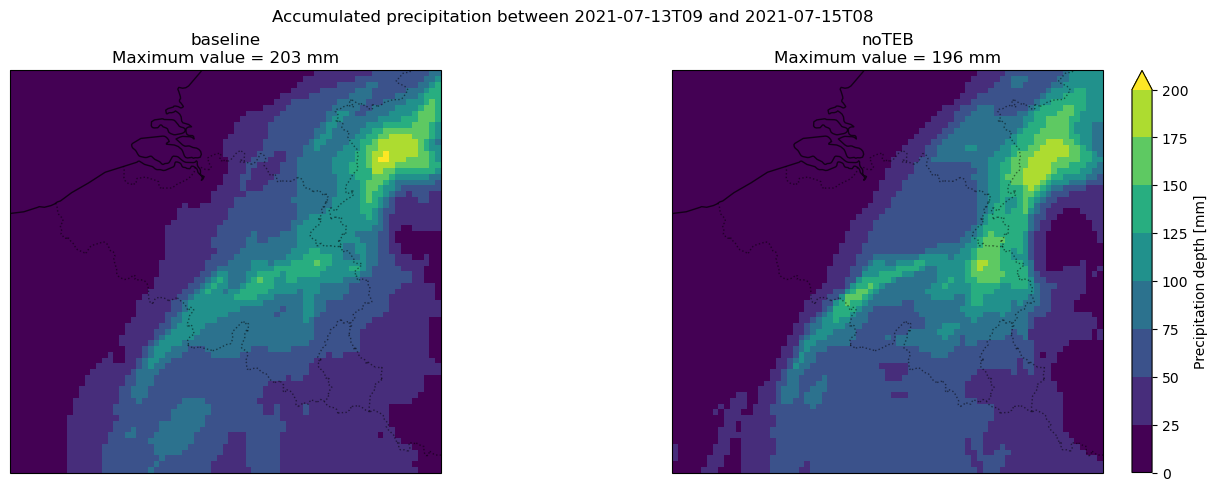

In [11]:
# Select a period out of the the data with tstart and tstop
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_period = ds.sel(time=slice(tstart, tstop))

# Select the precipitation out of the data and sum over time
pr_period = ds_period.pr
pr_period_sum = pr_period.sum(dim="time")

# Choose levels for the plot
levels = np.arange(0, 201, 25)

# Plot the data
fig, axs = plt.subplots(ncols=2, figsize=(12.8, 4.8), layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})

run_name_list = list(ds.coords["run_name"])

for idx in range(len(run_name_list)):
    ax = axs[idx]
    run_name = run_name_list[idx]

    pr_period_sum_run = pr_period_sum.sel(run_name=run_name)

    pr_plot = pr_period_sum_run.plot(ax=ax, x="lon", y="lat", levels=levels, add_colorbar=False, extend="max")
    # Set the title to show the maximum plotted value
    ax.set_title(f"{run_name.values}\nMaximum value = {pr_period_sum_run.max().values:.0f} mm")

    ax.coastlines(alpha=0.7)
    ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")

    # We found previously that while the resolution in degrees is different for the x- and y-axes, the resolution in kilometres is actually the same. To have this represented on the figure, we should therefore modify the aspect ratio accordingly:
    dlat = 0.045
    dlon = 0.07
    aspect_ratio = dlon / dlat
    ax.set_aspect(aspect_ratio)

# We give the color bar and the figure appropriate names
fig.colorbar(pr_plot, label="Precipitation depth [mm]")
fig.suptitle(f"Accumulated precipitation between {tstart} and {tstop}", fontsize="large")

# Show the plot!
plt.show()

In [13]:
filepath = "../data/CLIMATE_GRID_pr_1951_2023_daily_latlon_5km.nc"
obs_ds = xr.open_dataset(filepath, engine="netcdf4", chunks="auto")
obs_ds = convert_to_mm_h(obs_ds)
obs_ds

<xarray.Dataset>
Dimensions:  (time: 26663, lon: 75, lat: 70)
Coordinates:
  * time     (time) datetime64[ns] 1951-01-01 1951-01-02 ... 2023-12-31
  * lon      (lon) float64 2.0 2.07 2.14 2.21 2.28 ... 6.9 6.97 7.04 7.11 7.18
  * lat      (lat) float64 49.0 49.05 49.09 49.13 ... 51.97 52.02 52.06 52.1
Data variables:
    pr       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/14)
    CDI:                 Climate Data Interface version 1.9.9 (https://mpimet...
    Conventions:         CF-1.6
    creation_date:       25-06-2024
    creators:            Ghilain N., Van Schaeybroeck B., Vanderkelen I.
    contact:             inne.vanderkelen@meteo.be
    version:             1.1
    ...                  ...
    history:             Tue Jun 25 14:36:40 2024: cdo remapcon,latlon_5km.tx...
    CDO:                 Climate Data Operators version 1.9.9 (https://mpimet...
    freq:                daily
    spatial_resolution:  0.07° x 0.045° (~5km)
    region:              belgium
    dataset:             CLIMATE_GRID

In [19]:
obs_mask = ~obs_ds.pr.isnull().any("time")

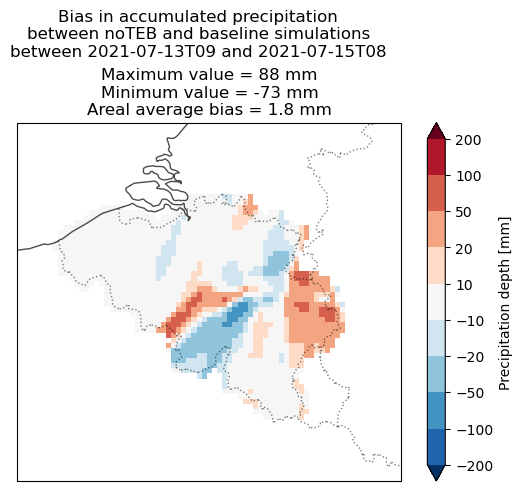

In [23]:
# Select a period out of the the data with tstart and tstop
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_period = ds.sel(time=slice(tstart, tstop))
pr_period = ds_period.pr
pr_period_sum = pr_period.sum(dim="time")

# Calculate bias/difference
bias_period_sum = pr_period_sum.sel(run_name="noTEB") - pr_period_sum.sel(run_name="baseline")
bias_period_sum = bias_period_sum.where(obs_mask)

# Choose levels for the plot
levels = [-200, -100, -50, -20, -10, 10, 20, 50, 100, 200]

# Plot the data
fig, ax = plt.subplots(layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})
pr_plot = bias_period_sum.plot(ax=ax, x="lon", y="lat", levels=levels, add_colorbar=False, extend="both")
ax.set_title(f"Maximum value = {bias_period_sum.max().values:.0f} mm\nMinimum value = {bias_period_sum.min().values:.0f} mm\nAreal average bias = {bias_period_sum.mean().values:.1f} mm")
ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")

dlat = 0.045
dlon = 0.07
aspect_ratio = dlon / dlat
ax.set_aspect(aspect_ratio)

fig.colorbar(pr_plot, label="Precipitation depth [mm]")
fig.suptitle(f"Bias in accumulated precipitation\nbetween noTEB and baseline simulations\nbetween {tstart} and {tstop}", fontsize="large")
plt.show()

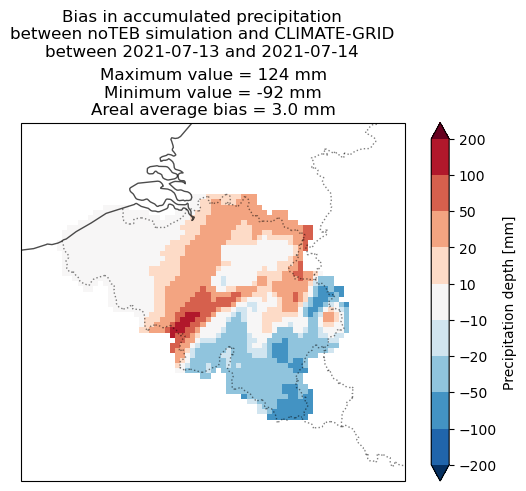

In [30]:
# Select a period out of the the data with tstart and tstop
run_name = "noTEB"
tstart = "2021-07-13T09"
tstop = "2021-07-15T08"
ds_period = ds.sel(time=slice(tstart, tstop))
pr_period = ds_period.pr
pr_period_sum = pr_period.sum(dim="time").sel(run_name=run_name)

# Select a period out of the the data with tstart and tstop
tstart = "2021-07-13"
tstop = "2021-07-14"
obs_ds_period = obs_ds.sel(time=slice(tstart, tstop))
obs_pr_period = obs_ds_period.pr
obs_pr_period_sum = obs_pr_period.sum("time", skipna=False) * 24

# Calculate bias/difference
bias_period_sum = pr_period_sum - obs_pr_period_sum

# Choose levels for the plot
levels = [-200, -100, -50, -20, -10, 10, 20, 50, 100, 200]

# Plot the data
fig, ax = plt.subplots(layout="constrained", subplot_kw={"projection" : ccrs.PlateCarree()})
pr_plot = bias_period_sum.plot(ax=ax, x="lon", y="lat", levels=levels, add_colorbar=False, extend="both")
ax.set_title(f"Maximum value = {bias_period_sum.max().values:.0f} mm\nMinimum value = {bias_period_sum.min().values:.0f} mm\nAreal average bias = {bias_period_sum.mean().values:.1f} mm")
ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")

dlat = 0.045
dlon = 0.07
aspect_ratio = dlon / dlat
ax.set_aspect(aspect_ratio)

fig.colorbar(pr_plot, label="Precipitation depth [mm]")
fig.suptitle(f"Bias in accumulated precipitation\nbetween {run_name} simulation and CLIMATE-GRID\nbetween {tstart} and {tstop}", fontsize="large")
plt.show()